In [1]:
import os
import pickle
from scipy import signal
import numpy as np
import pandas as pd
from tqdm import tqdm
from load_djembe_marker import *
from foot_module import onset_calculations, onset_extraction, onset_filtering, utils, onset_plot
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelmin, argrelmax
from pydub import AudioSegment
from scipy.signal import find_peaks
from pydub.generators import Triangle

from compute_tempo import *
from dance_evaluation import *
from mutils import DataHandler

In [2]:
# mvnfiles = ["BKO_E1_D1_01_Suku_T.mvnx", "BKO_E1_D1_02_Maraka_T.mvnx", "BKO_E1_D1_03_Wasulunka_T.mvnx", "BKO_E1_D2_04_Maraka_T.mvnx"]

# filename = mvnfiles[2]
# piece_name = os.path.basename(filename).split(".")[0]
# data_handler = DataHandler()
# motion_data, drum_onsets, start_f, end_f, start_t, end_t, cycle_onsets, beat_ref, bpm = data_handler.load_and_process_data(filename, mode = 'gr', drum = 'J2', section_idx=0)

### One Sensor

Loaded BKO_E1_D1_08_Suku_T.pkl
Error encountered for: Group 'gr' not found in the dataset.
Loaded BKO_E3_D5_03_Wasulunka_T.pkl
Total Sections: 1
A: 89.55597443042124
B: 83.79472770845385
bpm: 114.2032818416782


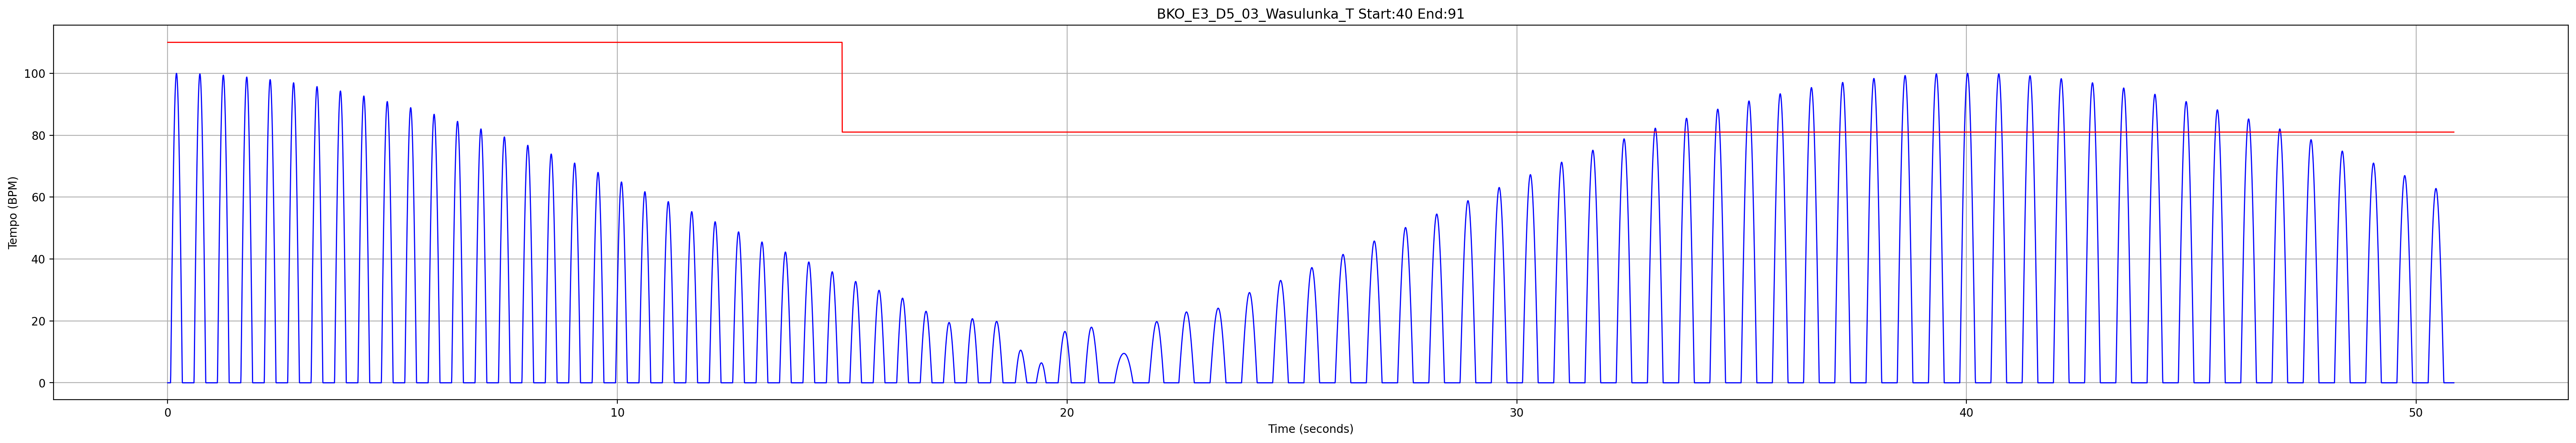

A: 92.80134404196033
B: 88.15800347078753
bpm: 114.2032818416782


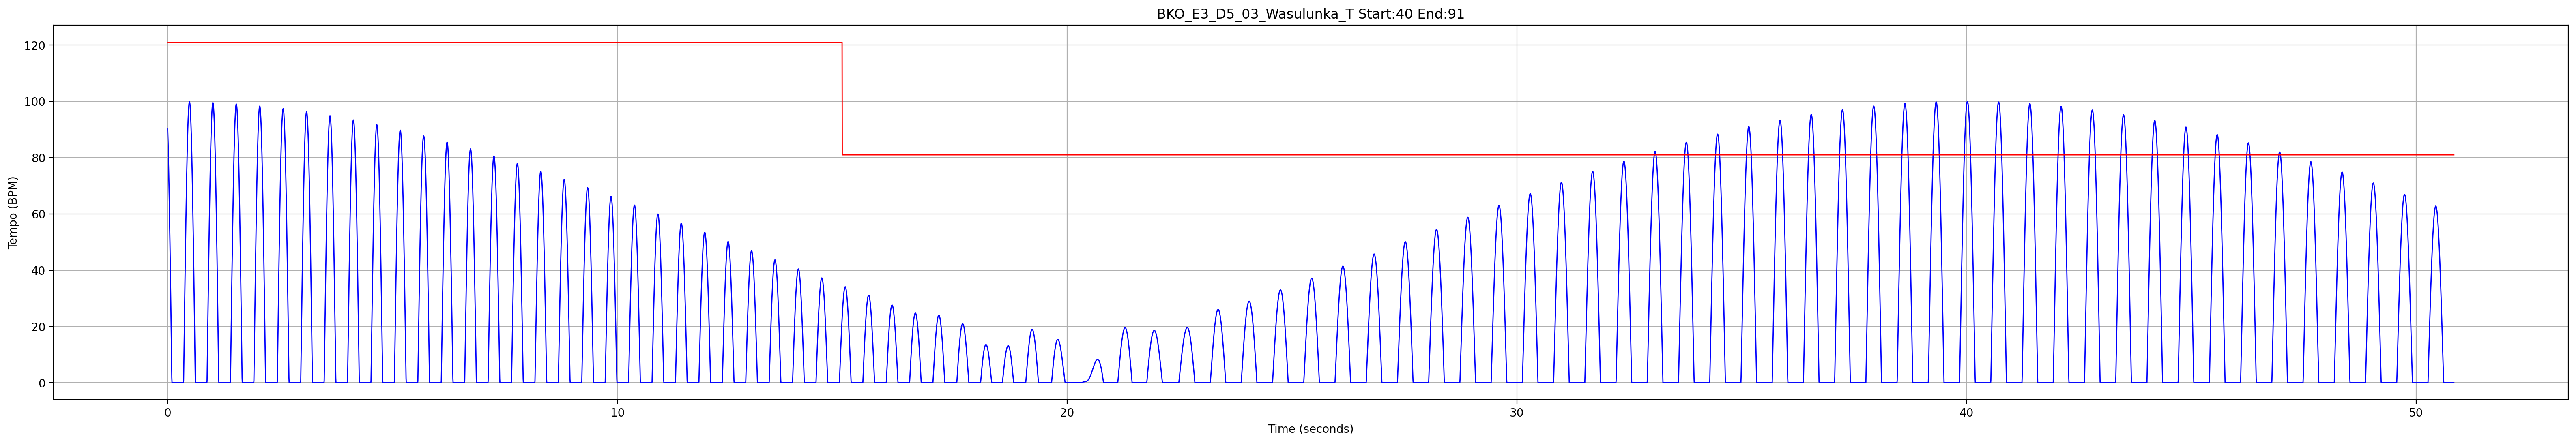

A: 126.09932797901983
B: 109.87521692422114
bpm: 114.2032818416782


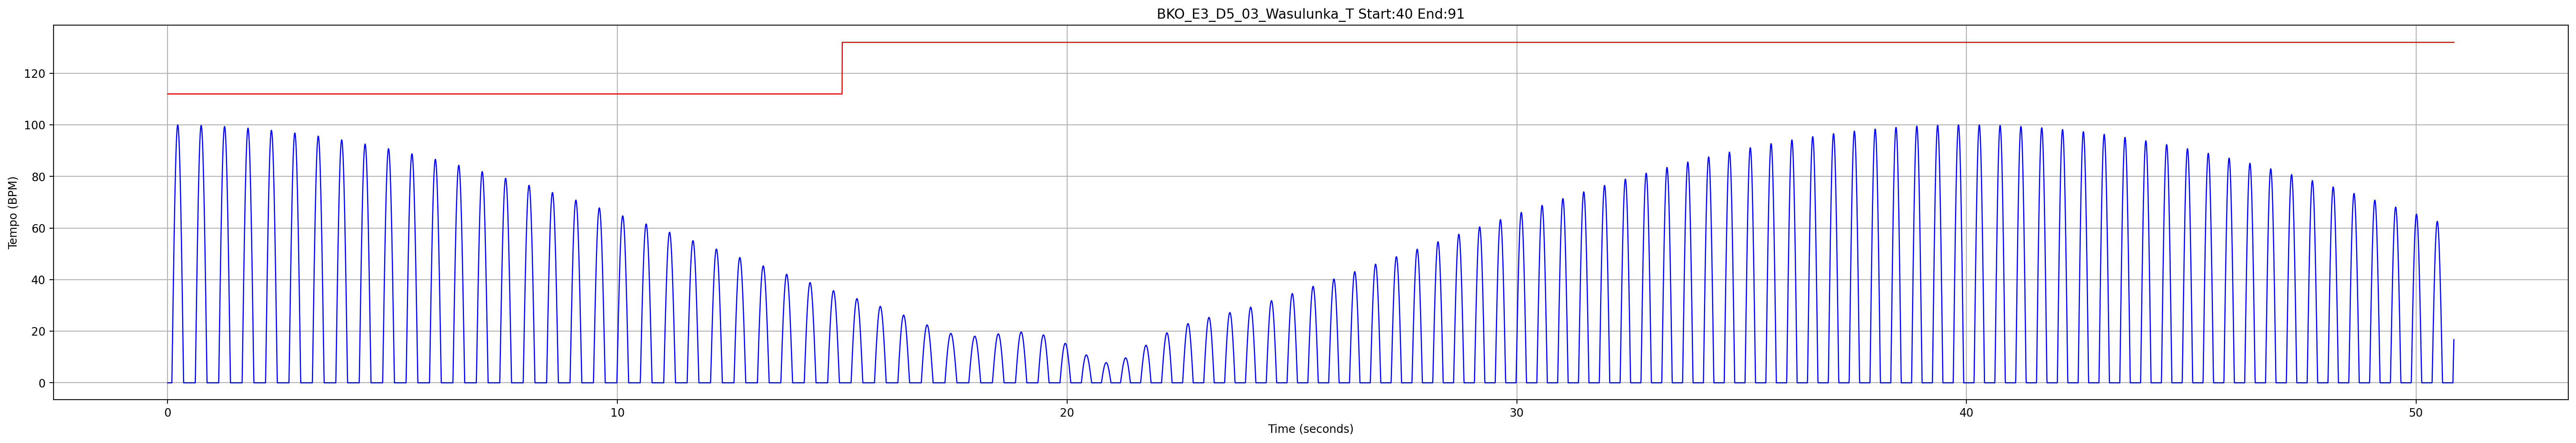

Loaded BKO_E2_D4_05_Sandia_T.pkl
Total Sections: 1
A: 72.92763157894737
B: 64.27152317880795
bpm: 91.98453195432808


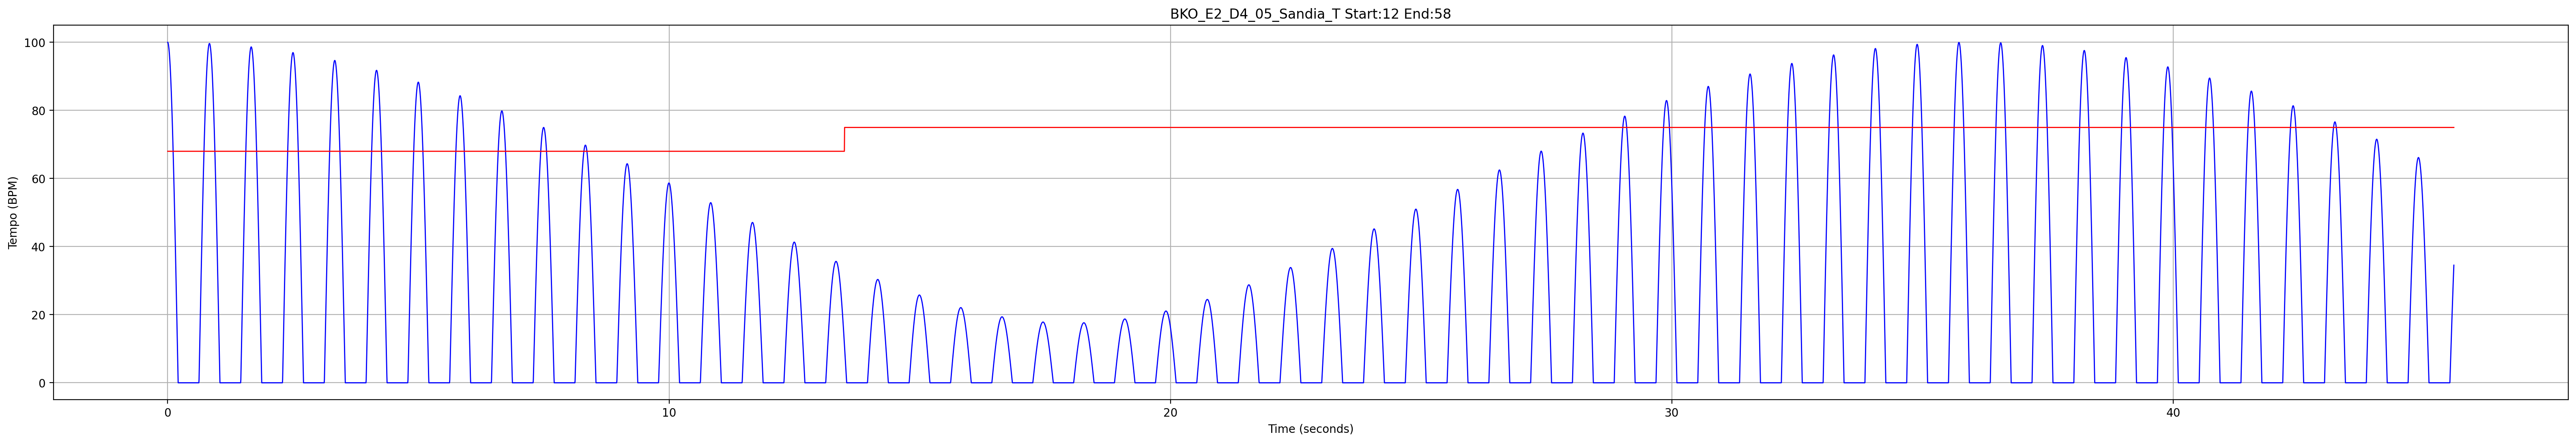

A: 94.61184210526316
B: 94.27152317880795
bpm: 91.98453195432808


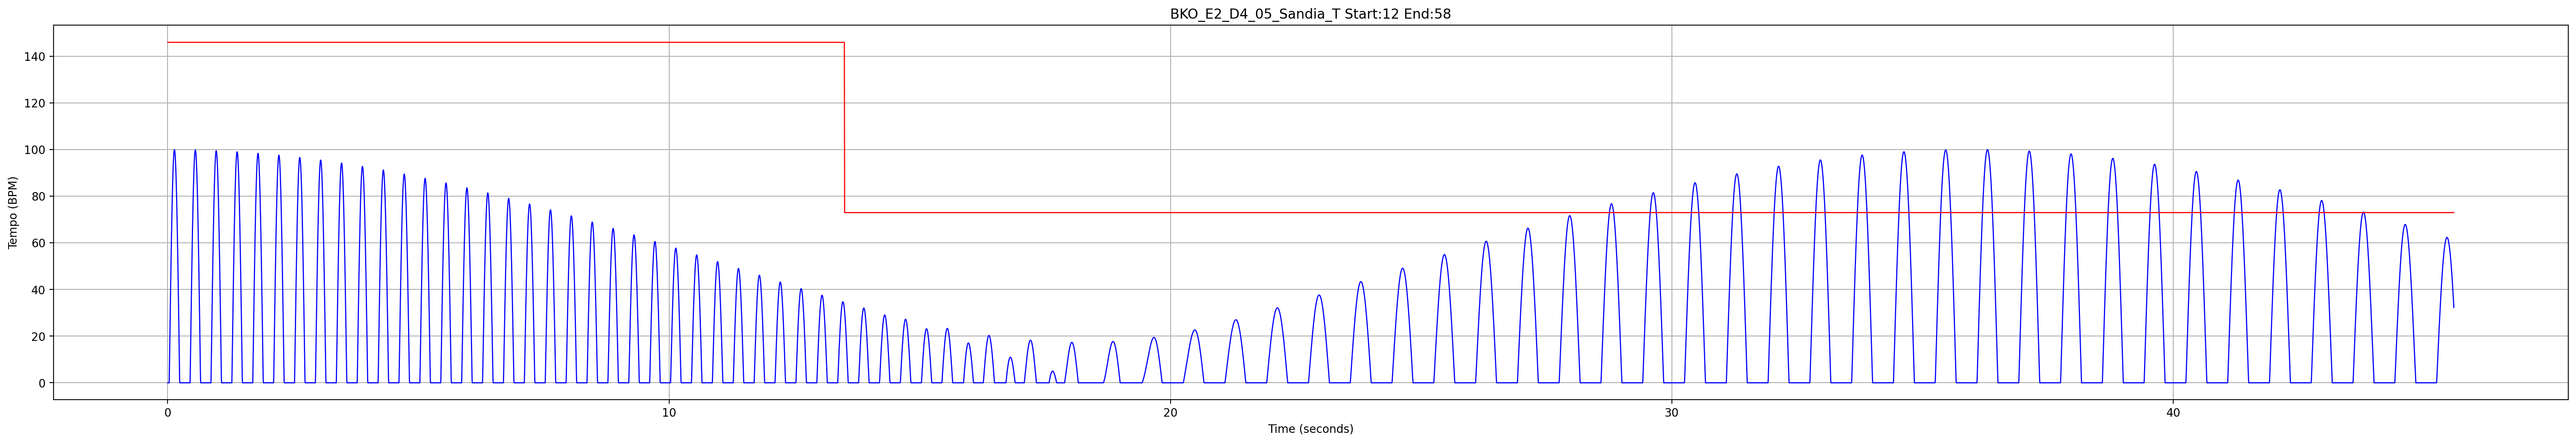

A: 103.22368421052632
B: 91.49006622516556
bpm: 91.98453195432808


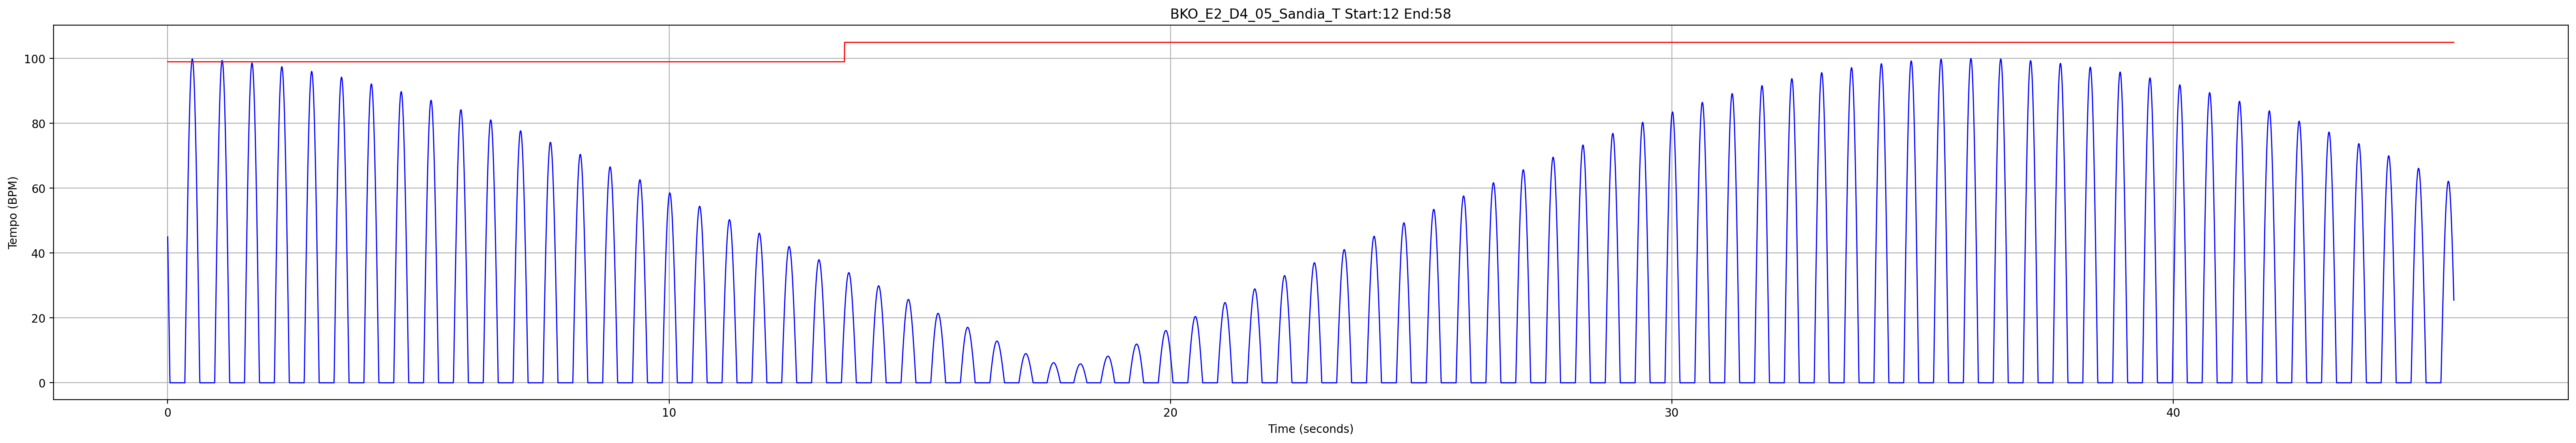

In [ ]:
# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT
pkl_filelist = os.listdir(f"/itf-fi-ml/home/sagardu/djembe_drive/sgr_pyspace/Dataset_V2")
data_handler = DataHandler()
result = {
    "piece": [],
    "bpm": [],
    "X_a": [],
    "Y_a": [],
    "Z_a": [],
    "X_b": [],
    "Y_b": [],
    "Z_b": [],
}

for idx, filename in enumerate(pkl_filelist):

    filename = filename.replace("_Dancers.csv", "_T.mvnx")
    piece_name = os.path.basename(filename).split(".")[0]
    try:
        motion_data, drum_onsets, start_f, end_f, start_t, end_t, cycle_onsets, beat_ref, bpm = data_handler.load_and_process_data(filename, mode = 'gr', drum = 'J2', section_idx=0)
    except ValueError as e:
        # Handle the error and continue
        print(f"Error encountered for: {e}")
        continue


    duration = int(end_t-start_t)
    w_sec = int(duration)
    h_sec = int(w_sec*0.8)
    
    mocap_fps = 240
    window_size = int(240*w_sec)
    hop_size = int(240*h_sec)
    tempi_range = np.arange(50,150,1)

    sensorA_velocity = motion_data['velocity']["SEGMENT_LEFT_FOOT"][start_f:end_f, :]
    sensorA_position = motion_data['position']["SEGMENT_LEFT_FOOT"][start_f:end_f, :]

    sensorA_velocity_norm = z_score_normalize(sensorA_velocity)
    sensorA_position_norm = z_score_normalize(sensorA_position)
    
    # sensorA_velocityde = detrend_signal_array(sensorA_velocity_norm, cutoff= 0.5)
    sensorA_positionde = detrend_signal_array(sensorA_position_norm, cutoff= 0.5)
    sensorA_positionde = smooth_velocity(sensorA_positionde, abs="no") # size (n, 3)
    
    novelty_length = len(sensorA_velocity)
    time_axis = np.arange(novelty_length)/mocap_fps
    # ax = 2
    for ax in range(3):
        sensorA_vel = sensorA_velocity_norm[:, ax].reshape(-1,1)
        sensorA_pos = sensorA_positionde[:, ax].reshape(-1,1)

        mode = "zero_uni"
        tempo_json_one_sensor = main_one_sensor_peraxis(sensorA_vel, sensorA_pos, 
                                                        mocap_fps, window_size, hop_size, tempi_range, 
                                                        distance_threshold=0.1, T_filter=0.25, vel_thres = 0.05,
                                                        mode=mode)

        # sensor_abs_vel = tempo_json_one_sensor["sensor_abs_vel"]
        # sensor_dir_onsets = tempo_json_one_sensor["sensor_dir_change_onsets"]
        # sensor_dir_onsets_f = tempo_json_one_sensor["sensor_dir_change_onsets_f"]
        sensor_onsets = tempo_json_one_sensor["sensor_onsets"]

        # tempogram_ab = tempo_json_one_sensor["tempogram_ab"]
        # time_axis_seconds = tempo_json_one_sensor["time_axis_seconds"]
        # tempo_axis_bpm = tempo_json_one_sensor["tempo_axis_bpm"]

        tempo_data_maxmethod = tempo_json_one_sensor["tempo_data_maxmethod"]
        tempo_data_weightedkernel = tempo_json_one_sensor["tempo_data_weightedkernel"]

        # Max method
        Aestimated_beat_pulse = tempo_data_maxmethod["estimated_beat_pulse"]
        Atempo_curve = tempo_data_maxmethod["tempo_curve"]
        bpmA_arr = tempo_data_maxmethod["bpm_arr"]
        # Atempo_curve_time_axis = tempo_data_maxmethod["tempo_curve_time_axis"]
        # Aglobal_tempo_bpm = tempo_data_maxmethod["global_tempo_bpm"]

        # Weighted method
        Bestimated_beat_pulse = tempo_data_weightedkernel["estimated_beat_pulse"]
        Btempo_curve = tempo_data_weightedkernel["tempo_curve"]
        bpmB_arr = tempo_data_weightedkernel["bpm_array"]
        # Btempo_curve_time_axis = tempo_data_weightedkernel["tempo_curve_time_axis"]
        # Bglobal_tempo_bpm = tempo_data_weightedkernel["global_tempo_bpm"]

        # combined_axis_onsets = np.sum(sensor_dir_onsets, axis=1)     # combine the onsets from 3 axes
        # combined_axis_onsets = np.where(combined_axis_onsets > 0, 1,0)
        # combined_axis_onsets = filter_dir_onsets_by_threshold(combined_axis_onsets.reshape(-1,1), threshold_s= 0.25)
        # combined_axis_onsets = combined_axis_onsets.flatten()   # Binary onsets

        # dance_onset, estimated_beat_onset, drum_ref, dance_onset_iois, estimated_beats_iois = data_handler.onsets_for_plotting(sensor_dir_onsets_f, Aestimated_beat_pulse, novelty_length)
        # dance_bpm = data_handler.calc_tempo_from_onsets(dance_onset)


        tempo_A = np.round(np.average(bpmA_arr), 2)
        tempo_B = np.round(np.average(bpmB_arr), 2)

        if ax == 0:
            result["piece"].append(piece_name)
            result["bpm"].append(np.round(bpm,2))
            result["X_a"].append(tempo_A)
            result["X_b"].append(tempo_B)
        elif ax == 1:
            result["Y_a"].append(tempo_A)
            result["Y_b"].append(tempo_B)
        elif ax == 2:
            result["Z_a"].append(tempo_A)
            result["Z_b"].append(tempo_B)

        print("A:", tempo_A)                           # [start_f:end_f]
        print("B:", tempo_B)
        print("bpm:", bpm)
        
        plt.figure(figsize=(40, 6), dpi=200)
        plt.plot(time_axis,100*Aestimated_beat_pulse, linewidth=1, color = 'b')
        plt.plot(time_axis, Atempo_curve, linewidth=1, color = 'r')        # [start_f:end_f]
        # plt.plot(100*sensor_onsets.flatten(), linewidth=1, color = 'r')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Tempo (BPM)')
        plt.title(f'{piece_name} Start:{round(start_t)} End:{round(end_t)}')
        plt.grid(True)
        plt.show()
        
    if idx == 3:
        break    
        
# results_df = pd.DataFrame(result)
# csv_filename = f"./results/log01/hand/peraxis/hand_peraxis_{mode}_50_150.csv"
# results_df.to_csv(csv_filename, index=False)
# print(f"Results saved to {csv_filename}")  

In [ ]:

plt.figure(figsize=(40, 6), dpi=200)
plt.plot(Atempo_curve[:len(sensor_onsets)])

In [ ]:
plt.figure(figsize=(40, 6), dpi=200)
plt.plot(sensor_onsets)

In [ ]:
tempogram_ab, tempogram_raw, time_axis_seconds, tempo_axis_bpm = compute_tempogram(sensor_abs_vel[start_f:end_f], mocap_fps, 
                                                                     window_length=window_size, hop_size=hop_size, tempi=tempi_range)

fig, axs = plt.subplots(1, 1, figsize=(6,6), dpi=100)

cax1 = axs.pcolormesh(time_axis_seconds, tempo_axis_bpm, tempogram_ab[0], shading='auto', cmap='magma')
axs.set_title('X-axis')
axs.set_xlabel('Time [s]')
axs.set_ylabel('Tempo [BPM]')
plt.colorbar(cax1, ax=axs, orientation='horizontal', label='Magnitude')
plt.show()

In [ ]:
plot_tempogram_perAxis(tempo_json_one_sensor, islog= 'no', dpi=100)

In [ ]:
plt.figure(figsize=(40, 6), dpi=200)
plt.plot(100*Aestimated_beat_pulse[start_f:end_f], linewidth=1, color = 'b')
plt.plot(Atempo_curve[start_f:end_f], linewidth=1, color = 'r')
plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title(f'{piece_name} Start:{round(start_t)} End:{round(end_t)}')
plt.grid(True)
plt.show()

In [ ]:
pos_b = np.where(sensorA_position[start_f:end_f]> 0, 1,0)
plt.figure(figsize=(40, 6), dpi=300)

plt.plot(sensor_abs_vel[start_f:end_f], linewidth = 1.0, color='b')
plt.plot(pos_b, linewidth = 1.0, color='b')
# plt.plot(sensor_dir_onsets_f[start_f:end_f], linewidth = 1.0, color='r')

In [ ]:
# Per mode: drum onset and directional change onset plot

plt.figure(figsize=(40, 6), dpi=300)
window_size = 0.1
for onset in beat_ref:
    window_start = onset - (window_size/2)  # Start of the window (25ms before)
    window_end = onset + (window_size/2)   # End of the window (25ms after)
    
    # Plot shaded window
    plt.axvspan(window_start, window_end, color='red', alpha=0.3)
    # Plot reference onset as a vertical line
    plt.axvline(onset, color='red', linestyle='--', linewidth=0.9)

plt.vlines(x= dance_onset, ymin=0.0, ymax=1, color='g', linewidth=1.2,)
# plt.vlines(x= estimated_beat_onset, ymin=0.0, ymax=1, color='b', linewidth=1.5,)
plt.xlabel('Time (seconds)')
plt.title(f'{piece_name}')
plt.grid(True)
plt.show()

In [ ]:
results = evaluate_dance_onsets_with_half_beats(beat_ref, dance_onset, tolerance=0.2)
print("\nEvaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")
print("-"*40)

In [ ]:
time = np.arange(novelty_length) / mocap_fps
peaks, properties = signal.find_peaks(Aestimated_beat_pulse)  # , prominence=0.02
beat_peaks_sec = time[peaks]

In [ ]:
click_duration = 50  # milliseconds
click_freq = 1200  # Hz
file_name ="maraka"
# Generate a single click sound
click = Triangle(click_freq).to_audio_segment(duration=click_duration)

onset_times = beat_peaks_sec  # kept_onsets/240   beat_peaks_sec
dN = novelty_length
total_duration = (dN/240)*1000  #  in milliseconds

audio = AudioSegment.silent(duration=total_duration)
for onset in onset_times:
    position = int(onset * 1000)  # Convert onset time to milliseconds
    audio = audio.overlay(click, position=position)

# Export the audio with clicks to a file
audio.export(os.path.join("/itf-fi-ml/home/sagardu/extract_feet_onset", f"{file_name}_Both_Foot_new.wav"), format="wav")
# audio.export(os.path.join("/itf-fi-ml/home/sagardu/extract_feet_onset", f"{file_name}_Bothhand_dir.wav"), format="wav")